# Developing an exploitative alternative to A/B testing

This is the code accompaning my [blog post](https://medium.com/@Lando-L/beyond-the-basics-reinforcement-learning-with-jax-part-ii-developing-an-exploitative-9423cb6b2fa5) on multi-arm bandits.

## Implementing the environment

For the code examples of this course, we will be using Python as our programming language, and will largely use Jax as our Machine Learning (ML) framework. Developed by Google, Jax is a Python library that is specifically designed for ML research. Unlike Tensorflow and PyTorch, it is built with the functional programming (FP) paradigm, making it highly composable and promoting the concept of pure functions that have no side effects. This means that all state changes, such as parameter updates or splitting of random generators, must be done explicitly. Although this may require more lines of code than their object-oriented programming (OOP) equivalent, it gives developers full control over state changes, leading to increased understanding of the code and fewer surprises.

In [134]:
import jax

# Numpy API with hardware acceleration and automatic differentiation
from jax import numpy as jnp
import numpy as np

# Low level operators
from jax import lax

# API for working with pseudorandom number generators
from jax import random

# Creates a function that evaluates the gradient of fun.
from jax import grad

import matplotlib.pyplot as plt

In [135]:
# Random seed to make our experiment replicable 
SEED = 42

# Number of visitors we want to simulate
NUM_VISITS = 10000

# Expected click rates for the five variants with the
CLICK_RATES = [0.042, 0.03, 0.035, 0.038, 0.045]

# PPossible prices which can be offered to client
PRICE_LIST = jnp.arange(0,1,0.05)

# Price Sensitivity Parameters for 4 Client Groups
FEATURE_SPACE = jnp.asarray([[0,1], [1,2], [0,3], [1,3]])
PRICE_SENSITIBITY_PARMS = [[3,-0.3], [3,-0.2], [3,-0.1], [3,-0.4]]

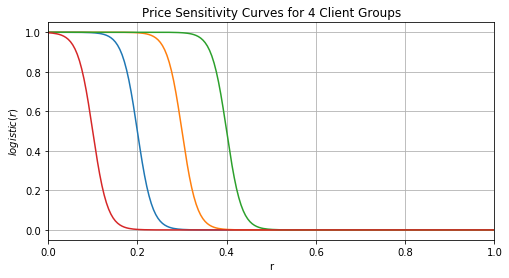

In [136]:
def price_sensitivity_curve(r, a, b):
    # a: slope
    # b: horizontal shift
    # scaling to (0,1) space
    r = a*20*(r-0.5-b)
    return 1-(1 / (1 + jnp.exp(-r)))

FS = (8, 4)  # figure size
r = jnp.linspace(0, 1, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, logistic(r, PRICE_SENSITIBITY_PARMS[0][0], PRICE_SENSITIBITY_PARMS[0][1]))

plt.plot(r, logistic(r, PRICE_SENSITIBITY_PARMS[1][0], PRICE_SENSITIBITY_PARMS[1][1]))

plt.plot(r, logistic(r, PRICE_SENSITIBITY_PARMS[2][0], PRICE_SENSITIBITY_PARMS[2][1]))

plt.plot(r, logistic(r, PRICE_SENSITIBITY_PARMS[3][0], PRICE_SENSITIBITY_PARMS[3][1]))
ax.grid()
_ = ax.set(xlabel="r", ylabel="$logistic(r)$", title="Price Sensitivity Curves for 4 Client Groups")
_ = ax.set_xlim(0, 1)

In [137]:
def visit(state, timestep, click_rates, policy_fn, update_fn):
    """
    Simulates a user visit.
    """

    # Unpacking the experiment state into
    # the agent's parameters and the random number generator
    params, rng = state

    # Splitting the random number generator
    next_rng, client_group_rng, policy_rng, user_rng = random.split(rng, num=4)

    # Selecting the variant to show the user, based on
    # the given policy, the agent's paramters, and the current timestep
    price = policy_fn(params, timestep, policy_rng)

    # simulate client type
    client_type = np.asarray(random.randint(client_group_rng, shape=[1], minval = 0, maxval = 3))[0]
    # Randomly simulating a purchase, based on
    # a Bernoulli Random variable where the parameter
    # p is obtained from the price sensitivity curve above
    p_tmp = price_sensitivity_curve(price, PRICE_SENSITIBITY_PARMS[client_group_tmp][0], PRICE_SENSITIBITY_PARMS[client_group_tmp][1])
    sold = np.asarray(jax.random.bernoulli(user_rng, p=p_tmp, shape=None))

    # Calculating the agent's updated parameters, based on
    # the current parameters, the selected variant,
    # and whether or not the user clicked
    next_params = update_fn(params, variant, clicked)
    
    # Returning the updated experiment state (params and rng) and
    # whether or not the user clicked
    return (next_params, next_rng), price, sold 

## Predictor and Cost Function

In [172]:
def logistic(r):
    return 1 / (1 + jnp.exp(-r))

def predict_proba(c, w, X, price):
    # append price into feature space
    X = jnp.append(jnp.asarray(X), jnp.expand_dims(np.asarray(price), axis=0), axis=0)
    return logistic(jnp.dot(X, w) + c)

In [139]:
def cost(c, w, X, y, eps=1e-14, lmbd=0.1):
    n = y.size
    p = predict_proba(c, w, X)
    p = jnp.clip(p, eps, 1 - eps)  # bound the probabilities within (0,1) to avoid ln(0)
    return -jnp.sum(y * jnp.log(p) + (1 - y) * jnp.log(1 - p)) / n + 0.5 * lmbd * (
        jnp.dot(w, w) + c * c
    )

## Implementing the policies

In [175]:
def params_init(n_feat):
    """
    Returns the initial action values
    """

    return {
        'c': 1.0,
        'w': 1.0e-5 * jnp.ones(n_feat+1)
    }

def action_value_update(params, X, price, sold):
    """
    Performs online-learning, i.e. SGD with reaction and cost function
    """
    # Converting the boolean clicked variable to a float value
    y = sold.astype(jnp.float32)
    
    c_current = c
    w_current = w
    # append price into feature space
    X = np.append(np.asarray(X), np.expand_dims(np.asarray(0.05), axis=0), axis=0)

    return {
        # Perform GRadient Descent on c
        'c': c_current - eta * grad(cost, argnums=0)(c_current, w_current, X, y),

        # Perform GRadient Descent on w
        'w': w_current - eta * grad(cost, argnums=1)(c_current, w_current, X, y)
    }

def reward(price):
    return price

def exploitive_action(params, features, price_list):
    # maximum expected reward
    return jnp.argmax(jnp.array([predict_proba(params['c'],params['w'],features, p) for p in price_list])*reward(price_list))

def reward(price):
    # turnover/profit genrated from sale
    return price

In [6]:
def epsilon_greedy_policy(params, client_type, timestep, rng, epsilon):
    """
    Randomly selects either the variant with highest action-value,
    or an arbitrary variant.
    """

    # Selecting a random variant
    def explore(q, rng):
        return random.choice(rng, jnp.arange(len(q)))
    
    # Selecting the variant with the highest action-value estimate
    def exploit(q, rng):
        return jnp.argmax(q)
    
    # Splitting the random number generator 
    uniform_rng, choice_rng = random.split(rng)
    
    # Deciding randomly whether to explore or to exploit
    return lax.cond(
        random.uniform(uniform_rng) < epsilon,
        explore,
        exploit,
        params['q'],
        choice_rng
    )

In [7]:
def boltzmann_policy(params, timestep, rng, tau):
    """
    Randomly selects a variant proportional to the current action-values
    """

    return random.choice(
        rng,
        jnp.arange(len(params['q'])),
        # Turning the action-value estimates into a probability distribution
        # by applying the softmax function controlled by tau
        p=jax.nn.softmax(params['q'] / tau)
    )

In [8]:
def upper_confidence_bound_policy(params, timestep, rng, confidence):
    """
    Selects the variant with highest action-value plus upper confidence bound
    """

    # Read n and q parameters
    n, q = params['n'], params['q']

    # Calculating each variant's upper confidence bound
    # and selecting the variant with the highest value
    return jnp.argmax(q + confidence * jnp.sqrt(jnp.log(timestep) / n))

In [9]:
def beta_init(num_variants):
    """
    Returns the initial hyperparameters of the beta distribution
    """

    return {
        'a': jnp.ones(num_variants, dtype=jnp.int32),
        'b': jnp.ones(num_variants, dtype=jnp.int32)
    }

def beta_update(params, variant, clicked):
    """
    Calculates the updated hyperparameters of the beta distribution
    """

    # Incrementing alpha by one
    def increment_alpha(a, b):
        return {'a': a.at[variant].add(1), 'b': b}
    
    # Incrementing beta by one
    def increment_beta(a, b):
        return {'b': b.at[variant].add(1), 'a': a}
    
    # Incrementing either alpha or beta
    # depending on whether or not the user clicked
    return lax.cond(
        clicked,
        increment_alpha,
        increment_beta,
        params['a'],
        params['b']
    )

In [10]:
def thompson_policy(params, timestep, rng):
    """
    Randomly sampling click rates for all variants
    and selecting the variant with the highest sample
    """

    return jnp.argmax(random.beta(rng, params['a'], params['b']))

## Implementing the evaluation

In [11]:
from functools import partial
from matplotlib import pyplot as plt

In [12]:
def evaluate(policy_fn, init_fn, update_fn):
    """
    Simulating the experiment for NUM_VISITS users
    while accumulating the click history
    """

    return lax.scan(
        # Compiling the visit function using just-in-time (JIT) compilation
        # for better performance
        jax.jit(
            # Partially applying the visit function by fixing
            # the click_rates, policy_fn, and update_fn parameters 
            partial(
                visit,
                click_rates=jnp.array(CLICK_RATES),
                policy_fn=jax.jit(policy_fn),
                update_fn=jax.jit(update_fn)
            )
        ),
        
        # Initialising the experiment state using
        # init_fn and a new PRNG key
        (init_fn(len(CLICK_RATES)), random.PRNGKey(SEED)),
        
        # Setting the number steps of the experiment
        jnp.arange(1, NUM_VISITS + 1)
    )

In [13]:
def regret(history):
    """
    Calculates the regret for every action in the experiment history
    """

    # Calculating regret with regard to picking the optimal (0.045) variant
    def fn(acc, reward):
        n, v = acc[0] + 1, acc[1] + reward
        return (n, v), 0.045 - (v / n)
    
    # Calculating regret values over entire history
    _, result = lax.scan(
        jax.jit(fn),
        (jnp.array(0), jnp.array(0)),
        history
    )
    
    return result

In [14]:
# Epsilon greedy policy
(epsilon_greedy_params, _), epsilon_greedy_history = evaluate(
    policy_fn=partial(epsilon_greedy_policy, epsilon=0.1),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# Boltzmann policy
(boltzmann_params, _), boltzmann_history = evaluate(
    policy_fn=partial(boltzmann_policy, tau=1.0),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# Upper confidence bound policy
(ucb_params, _), ucb_history = evaluate(
    policy_fn=partial(upper_confidence_bound_policy, confidence=2),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# Thompson sampling policy
(ts_params, _), ts_history = evaluate(
    policy_fn=thompson_policy,
    init_fn=beta_init,
    update_fn=beta_update
)

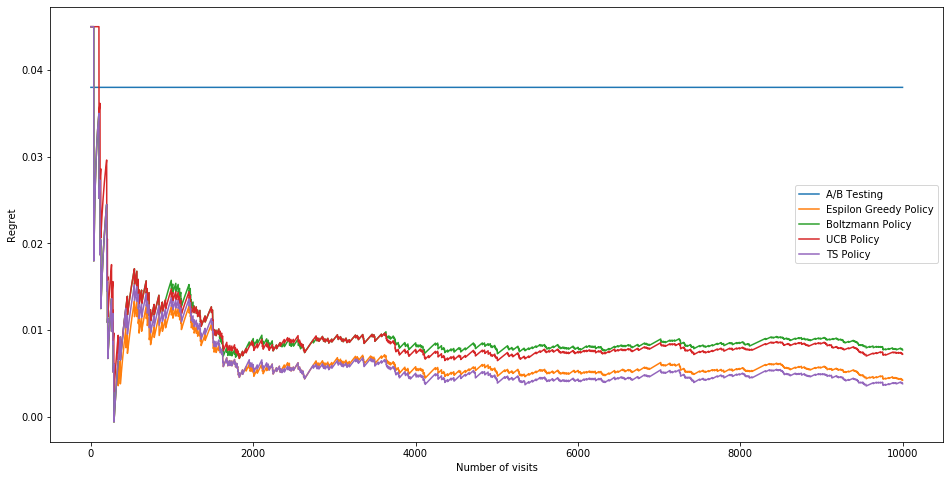

In [15]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = jnp.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of visits')
ax.set_ylabel('Regret')

ax.plot(x, jnp.repeat(jnp.mean(jnp.array(CLICK_RATES)), NUM_VISITS), label='A/B Testing')
ax.plot(x, regret(epsilon_greedy_history), label='Espilon Greedy Policy')
ax.plot(x, regret(boltzmann_history), label='Boltzmann Policy')
ax.plot(x, regret(ucb_history), label='UCB Policy')
ax.plot(x, regret(ts_history), label='TS Policy')

plt.legend()
plt.show()